In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import scipy.cluster.hierarchy as sch
from datetime import date
import cvxopt as opt
from cvxopt import blas, solvers

In [3]:
# Load data
stock_data = pd.read_csv('Stock_data.csv')
stock_data.head()

,Date,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,...,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZS,ZTS
0,02/01/19,170.43,76.04,36.11,159.04,166.52,80.50,83.76,351.08,72.36,...,34.24,27.65,116.60,175.06,69.08,33.98,48.29,4.50,48.32,87.14
1,01/31/19,172.84,76.05,35.77,159.20,166.44,80.29,83.37,351.07,72.98,...,35.09,27.45,109.56,173.60,67.53,34.81,47.59,4.48,48.37,86.16
2,01/30/19,170.47,75.44,36.34,159.04,165.25,79.06,78.53,339.59,71.68,...,33.60,26.80,108.46,171.36,65.93,33.34,47.98,4.47,45.52,85.09
3,01/29/19,169.44,73.56,36.29,155.39,154.68,77.47,79.54,330.38,69.69,...,32.95,27.28,105.66,170.71,64.63,32.64,48.25,4.42,45.17,84.41
4,01/28/19,168.05,73.27,36.57,154.86,156.30,77.14,80.12,336.90,69.05,...,32.68,27.42,105.84,172.24,65.91,32.43,48.80,4.38,45.59,83.65


In [4]:
# Drop empty columns
stock_data = stock_data.dropna(how='all', axis=1)

In [5]:
# Change data to be in increasing time
stock_data = stock_data.sort_index(ascending=0)

# Save dates for later plotting
Dates = stock_data['Date']

In [6]:
# Calculate daily returns
stock_data = stock_data.drop(['Date'],axis=1)
stock_data = np.log(stock_data)
stock_data = stock_data.diff()
stock_data.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Z,ZAYO,ZBH,ZBRA,ZEN,ZG,ZION,ZNGA,ZS,ZTS
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
813,-0.028559,-0.004186,-0.005718,-0.008119,0.001157,0.021435,-0.002864,-0.006392,0.009911,-0.029282,...,-0.012093,-0.016335,-0.005299,0.023101,0.012270,-0.012104,0.032453,-0.003884,NaN,0.011156
812,-0.009429,-0.005785,-0.015335,-0.019410,-0.004056,-0.014133,-0.002154,-0.017918,-0.012792,-0.019581,...,-0.007089,-0.012332,-0.003361,0.018731,0.018127,-0.006468,-0.004900,-0.019647,NaN,-0.003705
811,0.000206,0.001581,-0.003590,-0.004062,-0.032024,-0.014817,0.014980,0.027491,0.015637,0.022347,...,-0.036221,-0.050498,0.003175,-0.090886,0.001709,-0.022235,0.007828,0.000000,NaN,0.001745
810,0.005032,-0.008461,-0.002250,0.002881,-0.005668,-0.023385,-0.006392,-0.026487,-0.015194,-0.001005,...,-0.001641,0.012563,-0.005891,-0.006354,0.024047,-0.014480,-0.009794,0.007905,NaN,-0.017591


In [7]:
stock_data = stock_data.drop([814])
stock_data = stock_data.dropna(axis='columns')
column_names = stock_data.columns
#stock_data = stock_data[1:200] # use first 200 values

In [8]:
# Start portfolio part by splitting data to training and test data and get risk-free logreturn for same periods
stock_data = stock_data.set_index(Dates[1:len(Dates)])
training_returns = stock_data.head(round(len(stock_data.index)/2))
testing_returns = stock_data.tail(round(len(stock_data.index)/2))

# Calculate average returns and correlation matrix
training_return = training_returns.mean(axis=0)
training_corr = np.cov(training_returns,rowvar=0)

# Save values to calculate Markowitz' portfolio weights
return_df = pd.DataFrame(training_return)
return_df.to_csv('training_return',index=False)
training_corr_df = pd.DataFrame(training_corr)
training_corr_df.to_csv('training_covariance',index=False)

# Get mean risk-free returns from 3 month US treasury bond
risk_free_df = pd.read_csv('Risk_free.csv')
risk_free_df = risk_free_df.sort_index(ascending=0)

# Split to training and testing data
training_risk_free = risk_free_df.head(round(len(risk_free_df.index)/2))
testing_risk_free = risk_free_df.tail(round(len(risk_free_df.index)/2))

# Calculate mean daily logreturn
training_logrf = np.log(np.mean(np.power(1+training_risk_free['TMUBMUSD03M']/100,1/252)))
testing_logrf = np.log(np.mean(np.power(1+testing_risk_free['TMUBMUSD03M']/100,1/252)))

# Check that math makes sense for returns during training period
print('Simple returns over training period:')
print(np.power(np.mean(training_risk_free['TMUBMUSD03M'])/100+1,len(training_risk_free)/252))
print('Logarithmic returns over training period:')
print(np.exp(training_logrf*len(training_risk_free)))

# Save training logrf to use in Matlab
np.savetxt('training_logrf', np.array([training_logrf]))

Simple returns over training period:
1.0069419181411843
Logarithmic returns over training period:
1.0069375380235048


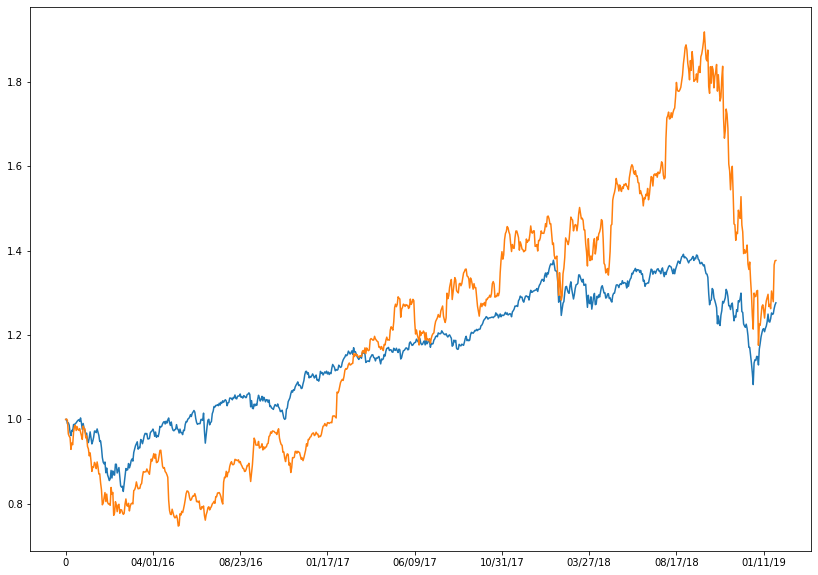

In [9]:
def cum_return_time_series(logreturns_df,weights):
    logreturns_df = logreturns_df.copy(deep=True)
    column_names = logreturns_df.columns
    
    # Start all returns from 1 so before taking exponential our value must be 0
    df2 = pd.DataFrame(np.zeros((1,len(logreturns_df.columns))), columns=column_names)
    logreturns_df = pd.concat([df2, logreturns_df])
    
    # Create weights dataframe for easy multiplication
    weights = {'Weights': weights}
    w = pd.DataFrame(data=weights,index=column_names)
    
    # Calculate weighted cumulative returns time series
    returns = logreturns_df.mul(w['Weights'],axis=1)
    daily_returns = returns.sum(axis=1)
    cum_return = np.exp(daily_returns).cumprod()
    return cum_return

def single_stock_time_series(logreturns_df,stock_ticker):
    # Easy plotting if you know ticker and want to use single stock
    logreturns_df.columns.get_loc(stock_ticker)
    w = np.zeros((len(logreturns_df.columns)))
    w[testing_returns.columns.get_loc(stock_ticker)] = 1
    time_series = cum_return_time_series(logreturns_df,w)
    return time_series

# Testing visualization over whole data
equal_p = cum_return_time_series(stock_data,np.arange(899)*0+1/899)
figure(figsize=(14,10))
equal_p.plot()
apple_p = single_stock_time_series(stock_data,'AAPL')
apple_p.plot()

In [10]:
# Solve Markowitz' weights using quadratic programming
# cvxopt offers faster optimization than scipy (possibly using interior-point method)
from cvxopt import matrix
from cvxopt.solvers import qp, options
import time

def solve_weights(Sigma, mu, leverage=1, shorting=False, rw=0.5):
    # Sigma is the covariance matrix
    # Mu is the returns vector
    # Leverage tells what the weights must sum to, default value 1 (100% of funds invested)
    # rw is the weight given to risk relative to returns
    
    Sigma_m = matrix(Sigma)
    mu_m = matrix(mu)
    n = len(mu)
    G_m = matrix(0.0, (n,n))
    G_m[::n+1] = -1.0
    h_m = matrix(0.0, (n,1))
    A_m = matrix(1.0, (1,n))
    b_m = matrix(leverage)
    
    options['show_progress'] = False
    
    #start_time = time.time()
    weights = qp((1-rw)*Sigma_m, -rw*mu_m, G_m, h_m, A_m, b_m)['x']
    
    #print("--- %s seconds ---" % (time.time() - start_time))
    
    weights = np.array(weights)
    return weights.flatten()

def get_highest_sharpe_weights(Sigma, mu, n_lambdas=50,leverage=1, use_H = False, H = 0):
    lambdas = []
    lambda_returns = []
    lambda_volatilities = []
    lambda_sharpes = []
    highest_sharpe = -1 # Hope best sharpe isn't lower than -1
    
    print('Looking for best weights')
    for i in range(0,n_lambdas):
        #print('Lambda {} out of {}'.format(i+1,n_lambdas))
        i_lambda = i/(n_lambdas-1)
        
        if not use_H:
            weights = solve_weights(Sigma,mu,1.0,False,i_lambda)
        else:
            weights = solve_weights(H,mu,1.0,False,i_lambda)
        
        # Add latest statistics to lists
        lambdas.append(i_lambda)
        lambda_returns.append(np.dot(mu,weights))
        lambda_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(Sigma, weights))))
        i_sharpe = (lambda_returns[i]-training_logrf)/lambda_volatilities[i]
        lambda_sharpes.append(i_sharpe)
        
        # Change weights if they lead to better sharpe
        if i_sharpe > highest_sharpe:
            #print('Best weights changed')
            best_weights = weights
            highest_sharpe = i_sharpe
    
    print('Best weights found')
    #plt.plot(lambdas,lambda_sharpes)
    return best_weights

Sigma = training_corr
mu = training_return

best_weights = get_highest_sharpe_weights(Sigma,mu,50)
best_return = np.dot(mu,best_weights)
best_vol = np.sqrt(np.dot(best_weights.T, np.dot(Sigma, best_weights)))
best_sharpe = (best_return-training_logrf)/best_vol
print('Highest sharpe ratio is {} for Sigma'.format(best_sharpe))

H = pd.read_csv('training_H') # estimated with training data and 500 s values
H = np.array(H)
best_weights = get_highest_sharpe_weights(Sigma,mu,50,1,True,H)
best_return = np.dot(mu,best_weights)
best_vol = np.sqrt(np.dot(best_weights.T, np.dot(Sigma, best_weights)))
best_sharpe = (best_return-training_logrf)/best_vol
print('Highest sharpe ratio is {} for H'.format(best_sharpe))

Looking for best weights
Best weights found
Highest sharpe ratio is 0.23928516252829563 for Sigma
Looking for best weights
Best weights found
Highest sharpe ratio is 0.20961350433645043 for H


In [10]:
# Calculating network-based variant H for covariance matrix Sigma from
# Smart network based portfolios by Clemente et al. (https://arxiv.org/pdf/1907.01274.pdf)

# None of the functions are parallellized so we need to do it as the operations are quite heavy
import multiprocessing
from joblib import Parallel, delayed

def adjacency_A(correlations_matrix,s):
    A = np.zeros((len(correlations_matrix),len(correlations_matrix)))
    A[correlations_matrix > s] = 1
    return A

def clustering_coefs(A):
    A = nx.from_numpy_matrix(A)
    coefs = nx.clustering(A)
    coefs = np.array(list(coefs.values()))
    return coefs

def clustering_coefs_A(correlations_matrix,s):
    A = adjacency_A(correlations_matrix,s)
    coefs = clustering_coefs(A)
    return coefs

def average_clustering(correlation_matrix,number_of_s):
    # Old not parallel function
    Cis = np.zeros((1,len(correlation_matrix)))
    for i in range(0,number_of_s):
        print('Calculating average clustering, {} out of {}'.format(i+1,number_of_s))
        s = -1+2/(number_of_s-1)*i
        A = adjacency_A(correlation_matrix,s)
        coefs = clustering_coefs(A)
        Cis = Cis + coefs
    Cis = Cis / (number_of_s)
    return Cis

def parallel_average_clustering(correlation_matrix,number_of_s):
    # Parallel computing of clustering coefficients
    i_values = np.arange(0,number_of_s)
    s_values = -1+2/(number_of_s-1)*i_values
    num_cores = multiprocessing.cpu_count()
    coefs = Parallel(n_jobs=num_cores)(delayed(clustering_coefs_A)(correlation_matrix,s) for s in s_values)
    coefs = np.asarray(coefs)
    Cis = np.average(coefs,axis=0)
    Cis = np.reshape(Cis,(1,len(correlation_matrix)))
    return Cis

def calculate_H(returns,number_of_s=50):
    # Returns is a dataframe with logarithmic returns of all stocks
    correlations = np.corrcoef(returns,rowvar=0)

    # Calculate C
    print("Calculating clustering coefficients")
    start_time = time.time()
    Cis = parallel_average_clustering(correlations,number_of_s)
    print("--- %s seconds ---" % (time.time() - start_time))
    print("Clustering coefficients found")
    
    cis = np.multiply(Cis,np.transpose(Cis))
    np.fill_diagonal(cis,1)

    # Calculate delta
    stds = np.std(returns,axis=0)
    delta_diag = stds/np.sqrt(np.sum(np.square(stds)))
    delta = np.diag(delta_diag)

    # Calculate H
    H = np.matmul(np.matmul(np.transpose(delta),cis),delta)
    return H

H = calculate_H(training_returns,3)
H = np.array(H)
best_weights = get_highest_sharpe_weights(Sigma,mu,50,1,True,H)
best_return = np.dot(mu,best_weights)
best_vol = np.sqrt(np.dot(best_weights.T, np.dot(Sigma, best_weights)))
best_sharpe = (best_return-training_logrf)/best_vol
print('Highest sharpe ratio is {} for H'.format(best_sharpe))

# Save H to optimize in MATLAB
#H_df = pd.DataFrame(H)
#H_df.to_csv('training_H_small_ns',index=False)

Calculating clustering coefficients
--- 44.49031090736389 seconds ---
Clustering coefficients found
Looking for best weights
Best weights found
Highest sharpe ratio is 0.20682194504741488 for H


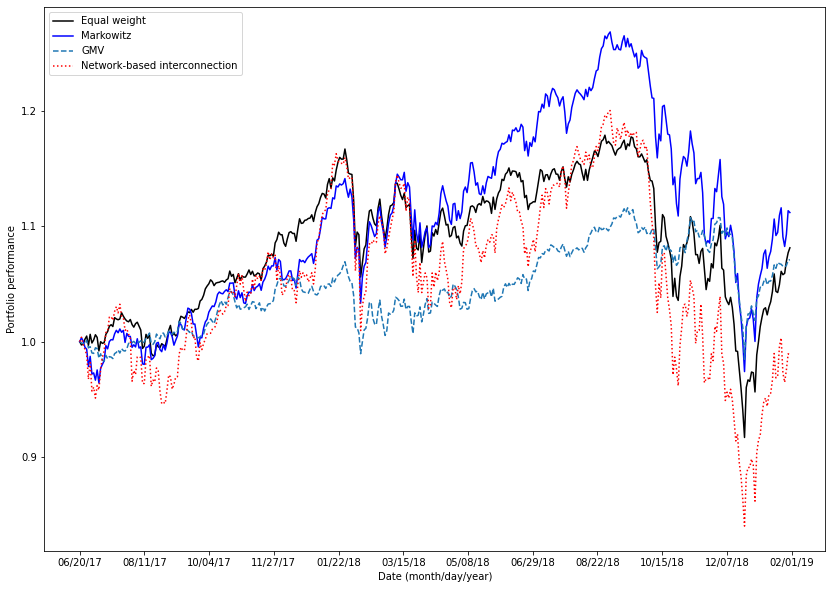

In [11]:
# Plot portfolio performance over testing data
figure(figsize=(14,10))
equal_weights = cum_return_time_series(testing_returns,np.arange(899)*0+1/899)
equal_weights.plot(c='k')
#apple_p = single_stock_time_series(testing_returns,'AAPL')
#apple_p.plot()

markowitz_w = pd.read_csv('Markowitz_weights',header=None)
markowitz_portfolio = cum_return_time_series(testing_returns,np.array(markowitz_w[0]))
markowitz_portfolio.plot(c='b')

GMV_w = pd.read_csv('GMV_weights',header=None)
GMV_portfolio = cum_return_time_series(testing_returns,np.array(GMV_w[0]))
GMV_portfolio.plot(ls='--')

network_w = pd.read_csv('network_weights',header=None)
network_portfolio = cum_return_time_series(testing_returns,np.array(network_w[0]))
network_portfolio.plot(ls=':',c='r')

plt.legend(('Equal weight','Markowitz','GMV','Network-based interconnection'))
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
plt.ylabel('Portfolio performance')

visible_labels = equal_weights.index[::37]
visible_labels.values[0] = '06/20/17' # Change starting date
num_labels = len(visible_labels)
plt.xticks(np.arange(0, len(equal_weights)+1, step=len(equal_weights)/(num_labels-1)),visible_labels)
plt.xlabel('Date (month/day/year)')

plt.savefig('Testing_time_series_graph')

In [12]:
# Calculate statistics for different portfolios
def calculate_statistics(logreturns_df, weights, risk_free_logreturn):
    logreturns_df = logreturns_df.copy(deep=True)
    column_names = logreturns_df.columns
    
    # Create weights dataframe for easy multiplication
    weights = {'Weights': weights}
    w = pd.DataFrame(data=weights,index=column_names)
    
    # Calculate weighted cumulative returns time series
    returns = logreturns_df.mul(w['Weights'],axis=1)
    daily_returns = returns.sum(axis=1)
    mu = np.mean(daily_returns)
    
    # Change to simple returns
    returns = np.exp(daily_returns)
    
    return_portfolio = np.prod(returns)
    volatility_portfolio = np.std(returns)
    sharpe_ratio = (mu-risk_free_logreturn)/volatility_portfolio
    return return_portfolio, mu, volatility_portfolio, sharpe_ratio;

df_w = pd.DataFrame()
df_w['Equal_weight'] = (np.zeros((1, len(testing_returns.columns)))+1/len(testing_returns.columns))[0]
df_w['Markowitz'] = markowitz_w[0]
df_w['Network'] = network_w[0]
df_w['GMV'] = GMV_w[0]
df_w.index = column_names

df_statistics = pd.DataFrame()
for portfolio in df_w:
    df_statistics[portfolio] = calculate_statistics(testing_returns,df_w[portfolio],testing_logrf)

df_statistics.index = ['Total return','Daily return','Volatility','Sharpe ratio']

# Make the table easier to read and compare
df_statistics = df_statistics.transpose()
print(df_statistics.head())

              Total return  Daily return  Volatility  Sharpe ratio
Equal_weight      1.081295      0.000192    0.008703      0.014292
Markowitz         1.111808      0.000260    0.009796      0.019677
Network           0.988749     -0.000028    0.013696     -0.006970
GMV               1.071034      0.000169    0.005737      0.017596


# Continue project with more indepth analysis
Some parts from before have been changed to be more general and help with the following analysis. Goal of the following parts is to backtest different approaches with rolling window testing.

In [13]:
# test different s values for calculating H (seems that s = 50 gives good enough values)
'''
number_of_ss = 2
multiple = 5
H_values = np.zeros((1,number_of_ss))
for s in range(1,number_of_ss+1):
    print(s*multiple)
    H = calculate_H(training_returns,s*multiple)
    H_values[0,s-1] = np.sum(H)
print(H_values)
plt.plot(multiple*np.arange(1,number_of_ss+1),H_values.T)
'''

'\nnumber_of_ss = 2\nmultiple = 5\nH_values = np.zeros((1,number_of_ss))\nfor s in range(1,number_of_ss+1):\n    print(s*multiple)\n    H = calculate_H(training_returns,s*multiple)\n    H_values[0,s-1] = np.sum(H)\nprint(H_values)\nplt.plot(multiple*np.arange(1,number_of_ss+1),H_values.T)\n'

In [25]:
# Define functions to get returns dataframe for given period for all strategies from return dataframe
def get_markowitz_weights(returns_df):
    mu = returns_df.mean(axis=0)
    Sigma = np.cov(returns_df,rowvar=0)
    best_weights = get_highest_sharpe_weights(Sigma,mu)
    return best_weights

def get_network_weights(returns_df):
    mu = returns_df.mean(axis=0)
    Sigma = np.cov(returns_df,rowvar=0)
    H = calculate_H(returns_df)
    best_weights = get_highest_sharpe_weights(Sigma,mu,50,1,True,H)
    return best_weights

In [39]:
# Define functions for calculating HRP weights 
# https://github.com/lcamposgarrido/data-science_projects/blob/master/others/hierarchical_risk_parity/HRP.ipynb
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, leaf_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def getHRP_weights(returns_df):
    cov_df = pd.DataFrame(np.cov(returns_df,rowvar=0))
    corr_df = pd.DataFrame(np.corrcoef(returns_df,rowvar=0))
    HRP_weights = getHRP(cov_df,corr_df)
    HRP_weights = HRP_weights.to_numpy()
    return HRP_weights

In [41]:
# Create rolling window backtesting
import datetime

stock_data.index = pd.to_datetime(stock_data.index)
returns_df = stock_data
risk_free_df = pd.read_csv('Risk_free.csv')
risk_free_df.index = pd.to_datetime(risk_free_df['Date'])
risk_free_df = risk_free_df.drop(['Date'],axis=1)

def get_rolling_window_returns_df(returns_df, risk_free_return_data, get_weights_function, window_size=30):
    rolling_returns_df = pd.DataFrame(index=returns_df.index,columns=returns_df.columns)
    indices = returns_df.index
    # First window is special as we don't have data to get weights
    
    # Use equal weights for first window
    weights = np.zeros((1,len(returns_df.columns)))+1/len(returns_df.columns)
    rolling_returns_df.loc[indices[0]:indices[0]+datetime.timedelta(days=window_size)] = \
        weights*returns_df.loc[indices[0]:indices[0]+datetime.timedelta(days=window_size)]

    # Get index for latest used date
    last_date = returns_df.loc[indices[0]:indices[0]+datetime.timedelta(days=window_size)].index[-1]
    last_date_index = returns_df.index.get_loc(last_date)
    print("Equal weights used till date {} (index={})".format(last_date,last_date_index))
    training_index = 0
    testing_index = last_date_index + 1
    
    while testing_index < len(returns_df.index)-1:
        # Calculate weights from previous window
        training_df = returns_df.loc[indices[training_index]:indices[training_index] + \
                                     datetime.timedelta(days=window_size)]
        weights = get_weights_function(training_df)
        
        # Calculate test returns from next window
        rolling_returns_df.loc[indices[testing_index]:indices[testing_index] + \
                               datetime.timedelta(days=window_size)] = \
            weights*returns_df.loc[indices[testing_index]:indices[testing_index] + \
                                   datetime.timedelta(days=window_size)]
        
        # Update training and testing indices
        training_index = testing_index
        last_date = returns_df.loc[indices[testing_index]:indices[testing_index] + \
                                   datetime.timedelta(days=30)].index[-1]
        testing_index = returns_df.index.get_loc(last_date) + 1
        print("Index {} out of {}".format(testing_index-1,len(returns_df.index)-1))
        
    rolling_summed_returns = rolling_returns_df.sum(axis=1)
    
    # Create a dataframe
    rolling_summed_returns = rolling_summed_returns.to_frame()
    rolling_summed_returns.columns = ['logreturns']
    return rolling_summed_returns

markowitz_returns = get_rolling_window_returns_df(returns_df, risk_free_df, get_markowitz_weights)
HRP_returns = get_rolling_window_returns_df(returns_df, risk_free_df, getHRP_weights)
#print("\n \n Network returns")
# Network calculation takes about 4 hours with 30 day rolling window using 8 cores
#network_returns = get_rolling_window_returns_df(returns_df, risk_free_df, get_network_weights)

Equal weights used till date 2015-12-04 00:00:00 (index=19)
Looking for best weights
Best weights found
Index 40 out of 813
Looking for best weights
Best weights found
Index 61 out of 813
Looking for best weights
Best weights found
Index 83 out of 813
Looking for best weights
Best weights found
Index 104 out of 813
Looking for best weights
Best weights found
Index 127 out of 813
Looking for best weights
Best weights found
Index 148 out of 813
Looking for best weights
Best weights found
Index 170 out of 813
Looking for best weights
Best weights found
Index 192 out of 813
Looking for best weights
Best weights found
Index 214 out of 813
Looking for best weights
Best weights found
Index 236 out of 813
Looking for best weights
Best weights found
Index 259 out of 813
Looking for best weights
Best weights found
Index 280 out of 813
Looking for best weights
Best weights found
Index 300 out of 813
Looking for best weights
Best weights found
Index 322 out of 813
Looking for best weights
Best wei

Index(['Markowitz'], dtype='object')
Mean return 0.00036152158932567665
Volatility Markowitz    0.009244
dtype: float64
Sharpe ratio (not adjusted for risk-free) Markowitz    0.039108
dtype: float64
Index(['HRP'], dtype='object')
Mean return 0.00025539208161148716
Volatility HRP    0.007315
dtype: float64
Sharpe ratio (not adjusted for risk-free) HRP    0.034913
dtype: float64
Index(['Network'], dtype='object')
Mean return -7.722287038353273e-05
Volatility Network    0.011153
dtype: float64
Sharpe ratio (not adjusted for risk-free) Network   -0.006924
dtype: float64
Index(['Equal'], dtype='object')
Mean return 0.0003000684157185702
Volatility Equal    0.008804
dtype: float64
Sharpe ratio (not adjusted for risk-free) Equal    0.034085
dtype: float64


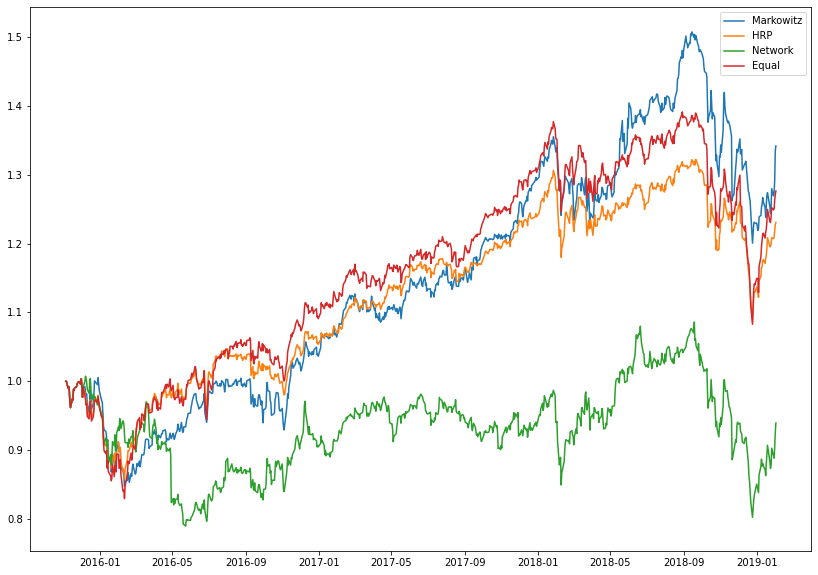

In [60]:
figure(figsize=(14,10))
def plot_cumulative_returns(logreturns_df):
    logreturns_df = logreturns_df.copy(deep=True)
    print(logreturns_df.columns)
    print("Mean return {}".format(np.average(logreturns_df)))
    print("Volatility {}".format(np.std(logreturns_df)))
    print("Sharpe ratio (not adjusted for risk-free) {}".format(np.average(logreturns_df)/np.std(logreturns_df)))
    
    # Start all returns from 1 so before taking exponential our value must be 0
    d = pd.Series(data=0, index = pd.Series(logreturns_df.index[0] - datetime.timedelta(days=1)))
    df = d.to_frame()
    df.columns = logreturns_df.columns
    logreturns_df = pd.concat([df, logreturns_df])
    
    cum_return = np.exp(logreturns_df).cumprod()
    return cum_return

markowitz_returns.columns = ['Markowitz']
markowitz_cumulative = plot_cumulative_returns(markowitz_returns)
plt.plot(markowitz_cumulative.index,markowitz_cumulative.values,label='Markowitz')

HRP_returns.columns = ['HRP']
HRP_cumulative = plot_cumulative_returns(HRP_returns)
plt.plot(HRP_cumulative.index,HRP_cumulative.values,label='HRP')

network_returns = pd.read_csv('network_rolling_logreturns.csv',index_col='Date')
network_returns.index = pd.to_datetime(network_returns.index)
network_cumulative = plot_cumulative_returns(network_returns)
plt.plot(network_cumulative.index,network_cumulative.values,label='Network')

equal_weights = returns_df.sum(axis=1)
equal_weights = equal_weights/899
equal_weights = equal_weights.to_frame()
equal_weights.columns = ['Equal']
equal_cumulative = plot_cumulative_returns(equal_weights)
plt.plot(equal_cumulative.index,equal_cumulative.values,label='Equal')
plt.legend()
plt.show()

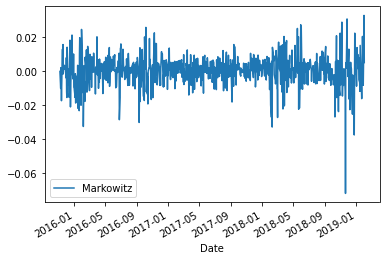

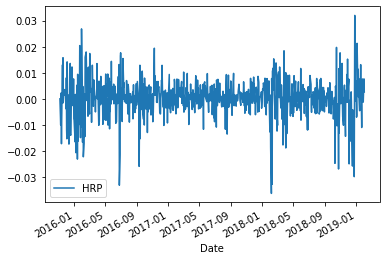

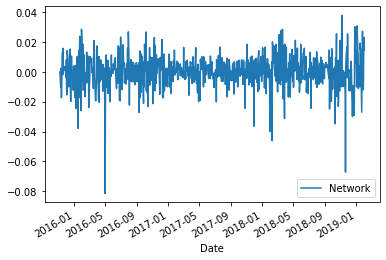

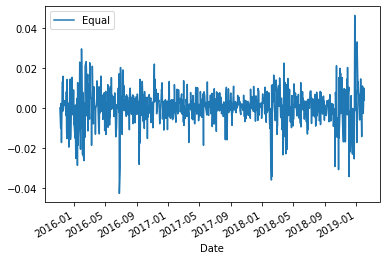

In [61]:
markowitz_returns.plot()
HRP_returns.plot()
network_returns.plot()
equal_weights.plot()
#network_returns.to_csv('network_rolling_logreturns.csv',index=True)